# Model Building


In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import utils
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy

#### Data Reading

In [30]:
#read in data
df = pd.read_csv("./data/classification_data.csv")
df_demo = pd.read_csv("./demographics-data/classification_data_demographics.csv")
df_demo = df_demo.drop(columns='pct_Asian')

In [31]:
#move target to end
df_demo = df_demo[[col for col in df_demo if col != 'labels']+ ['labels']]

In [32]:
df_demo.head()

,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,...,pct_AAPI,pct_Black,pct_Hispanic,pct_Multi-Racial/Ethnic,pct_Hawaiian/ Pacific Island,pct_White,pct_unemployed_2018,pct_u18_poverty_2017,median_hh_income_2017,labels
0,2,1,1,White,2,Simple Assault,Violent Crimes,Bar/Night Club,Anti-Black or African American,Race/Ethnicity/Ancestry,...,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0,1
1,2,2,2,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,...,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0,1
2,5,1,1,White,4,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,...,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0,1
3,9,1,1,White,1,Intimidation,Violent Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,...,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0,1
4,9,2,2,White,1,Intimidation,Violent Crimes,Convenience Store,Anti-Other Race/Ethnicity/Ancestry,Race/Ethnicity/Ancestry,...,0.27413,0.115603,0.234718,0.041847,0.008167,0.337067,0.03,0.105,95550.0,1


In [387]:
df.head()

,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,MostSeriousVictimType,WeaponType,Offensive_Act,labels
0,2,1,1,White,2,Simple Assault,Violent Crimes,Bar/Night Club,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,"Personal weapons (hands, feet, teeth, etc.)",Verbal slurs,1
1,2,2,2,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,None,Graffiti,1
2,5,1,1,White,4,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,Person,None,Daubing of swastika,1
3,9,1,1,White,1,Intimidation,Violent Crimes,Residence/Home/Driveway,Anti-Hispanic or Latino,Race/Ethnicity/Ancestry,Person,None,Verbal slurs,1
4,9,2,2,White,1,Intimidation,Violent Crimes,Convenience Store,Anti-Other Race/Ethnicity/Ancestry,Race/Ethnicity/Ancestry,Person,None,Verbal slurs,1


## Set X and y

In [34]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

X_demo = df_demo.iloc[:,:-1]
y_demo = df_demo.iloc[:,-1]

In [35]:
#Encode Features
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_encoded = ct.fit_transform(X)
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())

X_encoded_demo = ct.fit_transform(X_demo)
X_encoded_demo = pd.DataFrame(X_encoded_demo, columns=ct.get_feature_names_out())

#Scale X
X_ss = StandardScaler().fit_transform(X_encoded)
X_ss_demo = StandardScaler().fit_transform(X_encoded_demo)

### Train test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, stratify=y, random_state=13)
X_train_demo, X_test_demo, y_train_demo, y_test_demo = train_test_split(X_ss_demo, y_demo, stratify=y_demo, random_state=13)

In [37]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(X_train_demo.shape, X_test_demo.shape, y_train_demo.shape, y_test_demo.shape)

(18327, 150) (6109, 150) (18327,) (6109,)
(18327, 160) (6109, 160) (18327,) (6109,)


## Model Building

### Baseline Model

We have a very skewed dataset so our null baseline accuracy is 72.84%, however our null balanced accuracy score is 33.33%

In [22]:
y_train.value_counts(normalize=True)

1    0.728433
0    0.168713
2    0.102854
Name: labels, dtype: float64

In [27]:
null_preds = np.full_like(y_test, 1)
balanced_accuracy_score(y_test, null_preds)

0.3333333333333333

In [364]:
#Create Arrays of Model Scores
model_scores = [['Null Model', '.728433', '.33333','.728433', '.33333']]
demo_model_scores = [['Null Model', '.728433', '.33333','.728433', '.33333']]


In [351]:
#column names
cols = ["model", 'train_acc', 'train_balanced_acc', 'test_acc', 'test_balanced_acc']

### Logistic Regression

#### Without Demographic Data

In [111]:
params = {
    'C' : [.005,.01,.05],
    'class_weight' : [None]
}

log_reg = GridSearchCV(LogisticRegression(max_iter=10_000), params, n_jobs=-1, scoring='balanced_accuracy')
log_reg.fit(X_train, y_train)

print(log_reg.best_params_)


{'C': 0.05, 'class_weight': None}


In [365]:
#Add scores to array
model_scores.append([
    'Logistic Regression', 
    accuracy_score(y_train, log_reg.predict(X_train)), 
    log_reg.best_score_,
    accuracy_score(y_test, log_reg.predict(X_test)),
    log_reg.score(X_test, y_test), 
])

pd.DataFrame(model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.729252,0.337163,0.727615,0.335858


#### With Demographic Data

In [116]:
params = {
    'C' : [200, 250, 300],
    'class_weight' : [None]
}

log_reg_demo = GridSearchCV(LogisticRegression(max_iter=10_000), params, n_jobs=-1, scoring='balanced_accuracy')
log_reg_demo.fit(X_train_demo, y_train_demo)

print(log_reg_demo.best_params_)


{'C': 300, 'class_weight': None}


In [366]:
#Add scores to array
demo_model_scores.append([
    'Logistic Regression',
    accuracy_score(y_train, log_reg_demo.predict(X_train_demo)), 
    log_reg_demo.best_score_, 
    accuracy_score(y_test, log_reg_demo.predict(X_test_demo)),
    log_reg_demo.score(X_test_demo, y_test_demo), 
])

pd.DataFrame(demo_model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.916517,0.808671,0.90735,0.8034


#### Compare Confusion Matrix

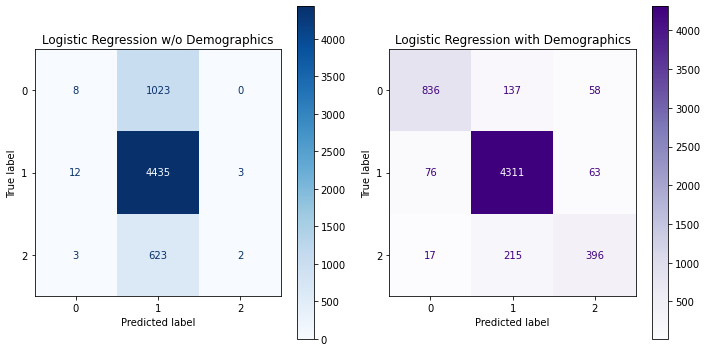

In [354]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("Logistic Regression w/o Demographics")
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, cmap='Blues', ax=ax[0])

ax[1].set_title("Logistic Regression with Demographics")
ConfusionMatrixDisplay.from_estimator(log_reg_demo, X_test_demo, y_test_demo, cmap='Purples', ax=ax[1])

plt.tight_layout()

### KNeighbors

KNN Models take a comparatively long time to predict and score

#### Without Demographic Data

In [131]:
params = {
    'n_neighbors' : [7],
    'weights' : ['uniform', 'distance'],
}
knn = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')

knn.fit(X_train, y_train)

print(knn.best_params_)


{'n_neighbors': 7, 'weights': 'distance'}


In [367]:
#Add scores to array
model_scores.append([
    'KNeighborsClassifier',
    accuracy_score(y_train, knn.predict(X_train)), 
    knn.best_score_,
    accuracy_score(y_test, knn.predict(X_test)),
    knn.score(X_test, y_test)
])

pd.DataFrame(model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.729252,0.337163,0.727615,0.335858
2,KNeighborsClassifier,0.978283,0.36139,0.668522,0.357807


#### With Demographic Data

In [140]:
params = {
    'n_neighbors' : [3,5,7, 9],
    'weights' : ['uniform', 'distance'],
}
knn_demo = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')

knn_demo.fit(X_train_demo, y_train_demo)

print(knn_demo.best_params_)



{'n_neighbors': 3, 'weights': 'distance'}


In [369]:
#Add scores to array
demo_model_scores.append([
    'KNeighborsClassifier',
    accuracy_score(y_train_demo, knn_demo.predict(X_train_demo)), 
    knn_demo.best_score_,
    accuracy_score(y_test_demo, knn_demo.predict(X_test_demo)),
    knn_demo.score(X_test_demo, y_test_demo), 

])

pd.DataFrame(demo_model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.916517,0.808671,0.90735,0.8034
2,KNeighborsClassifier,1.0,0.617526,0.826813,0.62552


#### Compare Confusion Matrix

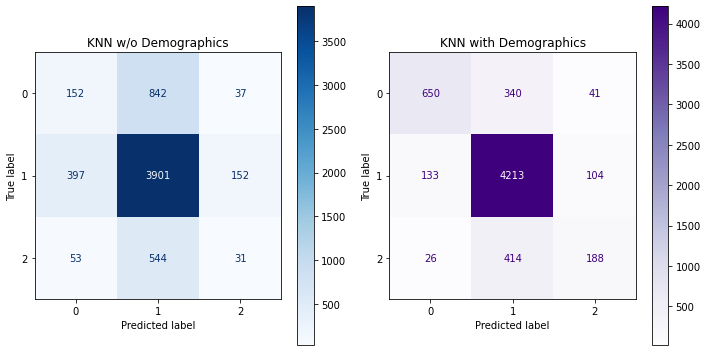

In [143]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("KNN w/o Demographics")
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap='Blues', ax=ax[0])

ax[1].set_title("KNN with Demographics")
ConfusionMatrixDisplay.from_estimator(knn_demo, X_test_demo, y_test_demo, cmap='Purples', ax=ax[1])

plt.tight_layout()

### Decision Tree

#### Without Demographics Data

In [144]:
params = {
    'max_depth' : [5, 10, 20, 50, None]
}
dt = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')

dt.fit(X_train, y_train)

print(dt.best_params_)

{'max_depth': None}


In [370]:
#Add scores to array
model_scores.append([
    'Decision Tree',
    accuracy_score(y_train, dt.predict(X_train)), 
    dt.best_score_,
    accuracy_score(y_test, dt.predict(X_test)),
    dt.score(X_test, y_test)
])
pd.DataFrame(model_scores, columns=cols)


,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.729252,0.337163,0.727615,0.335858
2,KNeighborsClassifier,0.978283,0.36139,0.668522,0.357807
3,Decision Tree,0.93676,0.367425,0.592732,0.367528


#### With Demographics Data

In [146]:
params = {
    'max_depth' : [5, 10, 20, 50, None]
}
dt_demo = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')

dt_demo.fit(X_train_demo, y_train_demo)

print(dt_demo.best_params_)


{'max_depth': 10}


In [371]:
#Add scores to array
demo_model_scores.append([
    'Decision Tree',
    accuracy_score(y_train_demo, dt_demo.predict(X_train_demo)), 
    dt_demo.best_score_,
    accuracy_score(y_test_demo, dt_demo.predict(X_test_demo)),
    dt_demo.score(X_test_demo, y_test_demo)
])

pd.DataFrame(demo_model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.916517,0.808671,0.90735,0.8034
2,KNeighborsClassifier,1.0,0.617526,0.826813,0.62552
3,Decision Tree,1.0,0.999823,1.0,1.0


#### Compare Confusion Matrix

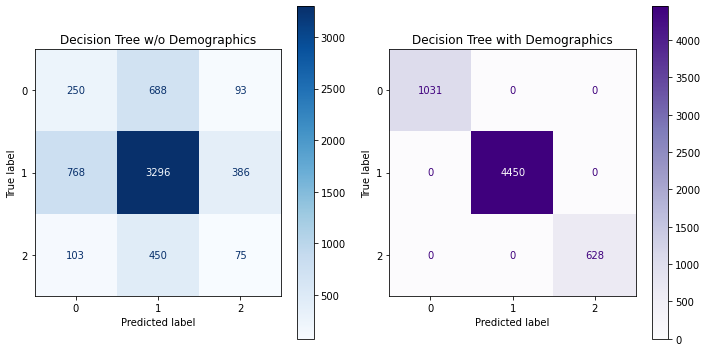

In [148]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("Decision Tree w/o Demographics")
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, cmap='Blues', ax=ax[0])

ax[1].set_title("Decision Tree with Demographics")
ConfusionMatrixDisplay.from_estimator(dt_demo, X_test_demo, y_test_demo, cmap='Purples', ax=ax[1])

plt.tight_layout()

### RandomForest

#### Without Demographics Data

In [216]:
params = {
    'n_estimators' :[50, 100, 150],
    'max_depth' : [10,20,30],
    'min_samples_split' : [2,3,5],
    'max_features' : ['sqrt']
}

rf = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')
rf.fit(X_train, y_train)

print(rf.best_params_)

{'max_depth': 30, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


In [373]:
#Add scores to array
model_scores.append([
    'RandomForest',
    accuracy_score(y_train, rf.predict(X_train)),
    rf.best_score_,
    accuracy_score(y_test, rf.predict(X_test)),
    rf.score(X_test, y_test)
])

In [374]:
pd.DataFrame(model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.729252,0.337163,0.727615,0.335858
2,KNeighborsClassifier,0.978283,0.36139,0.668522,0.357807
3,Decision Tree,0.93676,0.367425,0.592732,0.367528
4,RandomForest,0.887325,0.349322,0.708627,0.34688


#### With Demographics Data

In [158]:
params = {
    'n_estimators' :[50, 100, 150, 200],
    'max_depth' : [5,10,15,20],
    'min_samples_split' : [2,3,4,5]
}

rf_demo = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1, scoring='balanced_accuracy')
rf_demo.fit(X_train_demo, y_train_demo)

print(rf.best_params_)

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50}


In [375]:
#Add score to array
demo_model_scores.append([
    'RandomForest',
    accuracy_score(y_train_demo, rf_demo.predict(X_train_demo)),
    rf_demo.best_score_, 
    accuracy_score(y_test_demo, rf_demo.predict(X_test_demo)),
    rf_demo.score(X_test_demo, y_test_demo)
])
pd.DataFrame(demo_model_scores, columns=cols)

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.916517,0.808671,0.90735,0.8034
2,KNeighborsClassifier,1.0,0.617526,0.826813,0.62552
3,Decision Tree,1.0,0.999823,1.0,1.0
4,RandomForest,1.0,0.999798,1.0,1.0


#### Compare Confusion Matrix

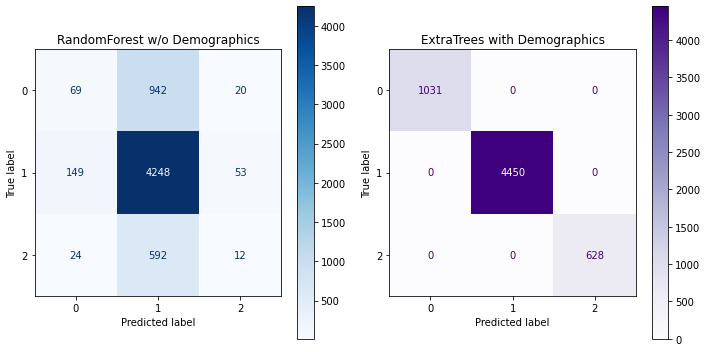

In [348]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].set_title("RandomForest w/o Demographics")
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap='Blues', ax=ax[0])

ax[1].set_title("ExtraTrees with Demographics")
ConfusionMatrixDisplay.from_estimator(rf_demo, X_test_demo, y_test_demo, cmap='Purples', ax=ax[1])

plt.tight_layout()

### Model Score Analysis

In [376]:
df_demo_scores = pd.DataFrame(demo_model_scores, columns=cols)
df_scores = pd.DataFrame(model_scores, columns=cols)

#### Without Demographics Data

In [377]:
df_scores

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.729252,0.337163,0.727615,0.335858
2,KNeighborsClassifier,0.978283,0.36139,0.668522,0.357807
3,Decision Tree,0.93676,0.367425,0.592732,0.367528
4,RandomForest,0.887325,0.349322,0.708627,0.34688


In [378]:
df_scores = df_scores.set_index("model")
df_scores = df_scores.astype('float')

In [379]:
df_scores.sort_values(by='test_balanced_acc')

,train_acc,train_balanced_acc,test_acc,test_balanced_acc
model,,,,
Null Model,0.728433,0.333330,0.728433,0.333330
Logistic Regression,0.729252,0.337163,0.727615,0.335858
RandomForest,0.887325,0.349322,0.708627,0.346880
KNeighborsClassifier,0.978283,0.361390,0.668522,0.357807
Decision Tree,0.936760,0.367425,0.592732,0.367528


The models that had the best balanced accuracy severely sacrificed thier test accuracy score.

#### With Demographics Data

In [380]:
df_demo_scores

,model,train_acc,train_balanced_acc,test_acc,test_balanced_acc
0,Null Model,.728433,.33333,.728433,.33333
1,Logistic Regression,0.916517,0.808671,0.90735,0.8034
2,KNeighborsClassifier,1.0,0.617526,0.826813,0.62552
3,Decision Tree,1.0,0.999823,1.0,1.0
4,RandomForest,1.0,0.999798,1.0,1.0


In [381]:
#Manually add the scores from the Neural Net
df_demo_scores.loc[7] = ['Neural Net', .9957, .9895, .9797, .9591]

In [383]:
df_demo_scores.iloc[:,1:] = df_demo_scores.iloc[:,1:].astype('float')
df_demo_scores.sort_values('test_balanced_acc', inplace=True)

In [384]:
df_demo_scores.set_index('model', inplace=True)

In [385]:
df_demo_scores

,train_acc,train_balanced_acc,test_acc,test_balanced_acc
model,,,,
Null Model,0.728433,0.333330,0.728433,0.33333
KNeighborsClassifier,1.000000,0.617526,0.826813,0.62552
Logistic Regression,0.916517,0.808671,0.907350,0.80340
Neural Net,0.995700,0.989500,0.979700,0.95910
Decision Tree,1.000000,0.999823,1.000000,1.00000
RandomForest,1.000000,0.999798,1.000000,1.00000


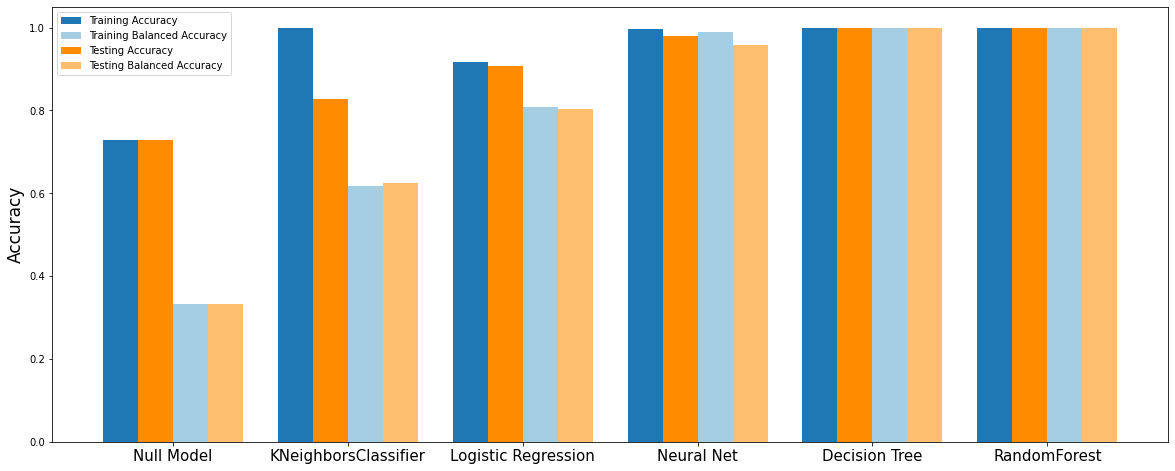

In [386]:
plt.figure(figsize=(20,8))
n = np.arange(len(df_demo_scores.index))
w = .2
plt.bar(n,df_demo_scores['train_acc'], width=w, label='Training Accuracy',color=sns.color_palette("Paired")[1])
plt.bar(n+w+w,df_demo_scores['train_balanced_acc'], width=w, label='Training Balanced Accuracy', color=sns.color_palette("Paired")[0])
plt.bar(n+w,df_demo_scores['test_acc'], width=w, label='Testing Accuracy', color='darkorange')
plt.bar(n+w+w+w,df_demo_scores['test_balanced_acc'], width=w, label='Testing Balanced Accuracy', color=sns.color_palette("Paired")[6])
plt.xticks(n+.3, df_demo_scores.index, fontsize=15)
plt.ylabel("Accuracy", fontsize=17)
plt.legend()
plt.savefig("./plots/model_scores.png")